#GMDL 222 -  PS 5 - Introduction to Uncertainty Estimation in Deep Neural Networks
## Methods:


*   SoftMax
*   MonteCarlo Dropout
* Temperature Scaling


In [67]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

# Import script from drive

In [68]:
from google.colab import drive
import sys

# import src/temperature_scaling.py
drive.mount('/content/gdrive/')
sys.path.append('gdrive/My Drive/DeepLearning/src')
from temperature_scaling import ModelWithTemperature


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Training

In [69]:
def fit(model, X, y, optimizer, criterion, device="cuda"):
  if isinstance(X, np.ndarray):
    X, y = torch.Tensor(X), torch.Tensor(y).long()
    if torch.cuda.is_available():
      X, y = X.to(device), y.to(device).long()
  for epoch in tqdm(range(1000)):
    # no batches, predict the entire set
    output = model(X)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
  model.eval()

## Model - MLP

In [70]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, mcdo=False):
        super(MLP, self).__init__()
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.fc_hidden1 = nn.Linear(hidden_size, hidden_size)
        self.fc_hidden2 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        # MonteCarlo Dropout
        self.mcdo = mcdo
        if self.mcdo:
          self.dropout_layer = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.relu(self.fc_in(x))
        x = self.relu(self.fc_hidden1(x))
        if self.mcdo:
         x = self.dropout_layer(x)
        x = self.relu(self.fc_hidden2(x))
        x = self.fc_out(x)
        return x
    def predict(self, x):
      n_passes = 1
      preds = []
      if self.mcdo:
        n_passes = 1000
        # dropout during inference
        self.dropout_layer.train()
        for i in range(n_passes):
          pred = self.forward(x)
          preds.append(pred)
        # add a new dim at dim=0 which we will mean over
        preds = torch.stack(preds, dim=0)
        return preds.mean(dim=0)
      else:
        pred = self.forward(x)
        return pred

      
      

In [71]:
criterion = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)
device = "cuda"
hidden_size = 32
input_size = 2
output_size = 2

# Uncertainty Estimation in Deep Learning

## Monte Carlo Dropout (MCDO) [1]
Monte Carlo Dropout
refers to performing $T$ stochastic forward passes
through the network and averaging the result. Each forward pass, while Dropout is "activate" is equivilant to sampling a set of weights from the set of all neural networks trained on that specific problem.

\begin{equation}
f(x;w)=\frac{1}{T}\sum_{i=1}^{T}f(x,w_i)
\end{equation}
where $w_i$ is a random sample of the network's weights.

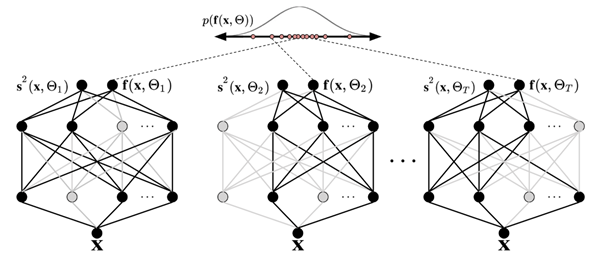

## Temperature Scaling [2]
For classification problems, the neural network output a vector known as the logits. The logits vector is passed through a softmax function to get class probabilities. Temperature scaling simply divides the logits vector by a learned scalar parameter, i.e.

\begin{equation}
\sigma(z_i) = \frac{e^{z_{i}}/T}{\sum_{j=1}^K e^{z_{j}}/T} \ \ \ for\ i=1,2,\dots,K
\end{equation}
We learn this parameter on a validation set, where $T$ is chosen to minimize negative log likelihood (NLL). Intuitively, temperature scaling simply softens the neural network outputs. This makes the network slightly less confident, which makes the confidence scores reflect true probabiliti

Implementation from https://github.com/gpleiss/temperature_scaling

# Evaluation
## Confidence histograms and reliability diagrams
Reliability diagrams are simply graphs of the Observed frequency of an event plotted against the Forecast probability of an event. This effectively tells the user how often (as a percentage) a forecast probability actually occurred.

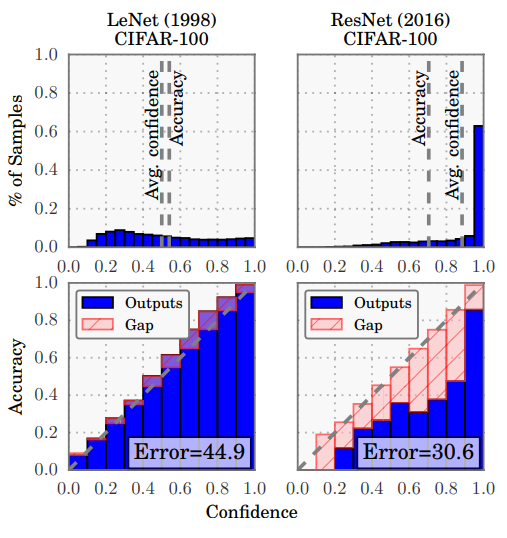

Confidence histograms (top) and reliability diagrams
(bottom) for a 5-layer LeNet (left) and a 110-layer ResNet (right)
on CIFAR-100. 

# Metric - Expected Calibration Error (ECE)
\begin{equation}
ECE =\sum_{m=1}^{M}\frac{|Bm|}{n}|acc(B_m) − conf(B_m)|
\end{equation}

$B_m$ = bin number





### Refernces
[1] - Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning (ICML 2016)

[2] On Calibration of Modern Neural Networks (ICML 2017)

# Test on generated data

In [72]:
def make_spirals(n_samples=100, noise=0.05):
  N = n_samples # number of points per class
  D = 2 # dimensionality
  K = 2 # number of classes
  X = np.zeros((N*K,D)) # data matrix (each row = single example)
  y = np.zeros(N*K, dtype='uint8') # class labels
  for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*3,(j+3)*3,N) + np.random.randn(N)*noise # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

  return X, y

## Using scikit-learn API
Modified from sklearn [classifier comparison example](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

In [73]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [74]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for GMDL222 by Ron Shapira Weber

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.nn.functional import softmax
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
#from sklearn.inspection import DecisionBoundaryDisplay


names = [
    "MLP",
    "MonteCarloDropout",
    "TemperatureScaling"
]

N = 600
X, y = make_classification(n_samples=N, class_sep=2, flip_y=0.1,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2
)
rng = np.random.RandomState(2)
X += 1.5*rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_moons(n_samples=N, noise=0.1, random_state=0),
    make_circles(n_samples=N, noise=0.1, factor=0.5, random_state=1),
    make_blobs(n_samples=N, centers=2, n_features=2, random_state=0),
    make_spirals(n_samples=N, noise=0.2)
]


## Train all classifiers

100%|██████████| 1000/1000 [00:01<00:00, 758.21it/s]


Before temperature - NLL: 0.440, ECE: 0.107
Optimal temperature: 2.034
After temperature - NLL: 0.375, ECE: 0.090


100%|██████████| 1000/1000 [00:01<00:00, 656.21it/s]


Before temperature - NLL: 0.001, ECE: 0.001
Optimal temperature: 1.318
After temperature - NLL: 0.003, ECE: 0.003


100%|██████████| 1000/1000 [00:01<00:00, 761.52it/s]


Before temperature - NLL: 0.015, ECE: 0.013
Optimal temperature: 1.240
After temperature - NLL: 0.019, ECE: 0.017


100%|██████████| 1000/1000 [00:01<00:00, 754.64it/s]


Before temperature - NLL: 0.208, ECE: 0.054
Optimal temperature: 1.680
After temperature - NLL: 0.177, ECE: 0.052


100%|██████████| 1000/1000 [00:01<00:00, 746.41it/s]


Before temperature - NLL: 0.079, ECE: 0.020
Optimal temperature: 0.759
After temperature - NLL: 0.085, ECE: 0.021


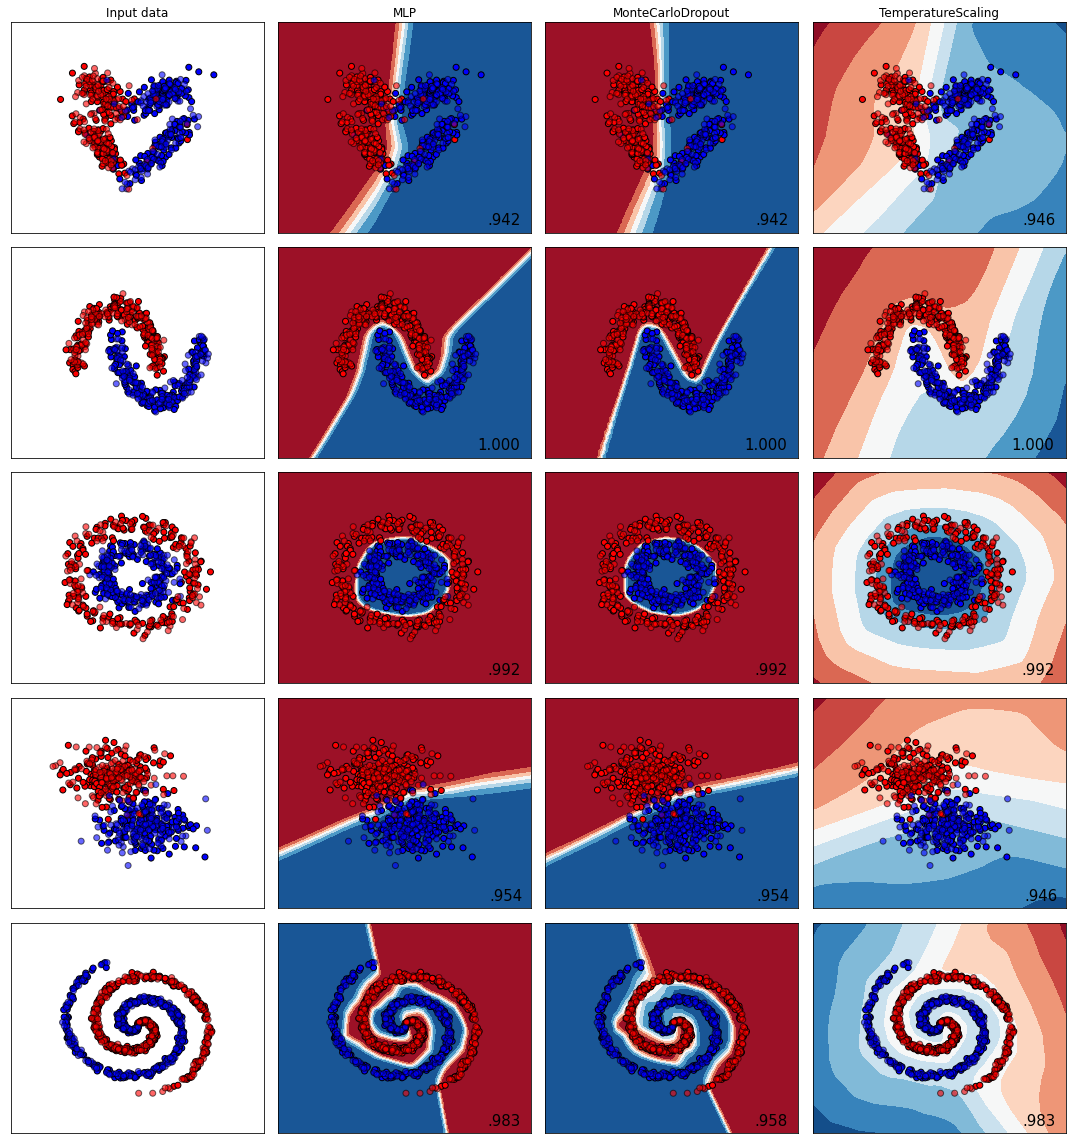

In [75]:
n_clf = len(names)
figure = plt.figure(figsize=(5*n_clf, 16))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )
    # create validation set, used for tempScale
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    X_val, y_val = torch.Tensor(X_val), torch.Tensor(y_val).long()
    valid_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32,
                                          shuffle=True, num_workers=2)
    x_min, x_max = X[:, 0].min() - 1.5, X[:, 0].max() + 1.5
    y_min, y_max = X[:, 1].min() - 1.5, X[:, 1].max() + 1.5

    # Generate mesh-grid for decision boudray
    xs = torch.linspace(x_min, x_max, steps=100)
    ys = torch.linspace(y_min, y_max, steps=100)
    xx_m, yy_m = torch.meshgrid(xs, ys, indexing='xy')
    xx, yy = xx_m.ravel(), yy_m.ravel()
    xy_coord = torch.stack([xx, yy], dim=1)

    # for plot
    xx_m, yy_m = xx_m.numpy(), yy_m.numpy()

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(names) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name in names:
        ax = plt.subplot(len(datasets), len(names) + 1, i)
        # init model by reseting weights (since we already used init 
        use_mcdo = False
        if name == "MonteCarloDropout":
          use_mcdo = True
        clf = MLP(input_size, hidden_size, output_size, mcdo=use_mcdo)
        clf = clf.to(device)
        optimizer = optim.SGD(clf.parameters(), lr=0.1)
        fit(clf, X_train, y_train, optimizer, criterion)
        
        # evaluation
        clf.eval()
        # if temperature scaling:
        if name == "TemperatureScaling":
          clf = ModelWithTemperature(clf)
          clf.set_temperature(valid_loader)

        X_test_t = torch.tensor(X_test).float().to(device)
        y_pred = clf.predict(X_test_t).detach().cpu().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        score = np.mean(y_test==y_pred)
        #  DecisionBoundary
        decision_bound = clf.predict(xy_coord.to(device)).detach().cpu()
        # convert to probabilites
        if name != "TemperatureScaling":
          decision_bound = softmax(decision_bound, dim=1)
        decision_bound = decision_bound.numpy()
        # take prediciton for class 1
        decision_bound = decision_bound[:, 1].reshape(xx_m.shape)
        #ax.scatter(xx_m, yy_m, c=decision_bound, cmap=cm_bright, alpha=0.6)
        c = ax.contourf(xx_m, yy_m, decision_bound, cmap='RdBu')

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            f"{score:.3f}".lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1
        torch.cuda.empty_cache()
plt.tight_layout()
plt.show()